# Inference - Whole Slide

Contains: 
- Inference per whole slide (merged patches)

### Import Packages

In [2]:
import torch 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import sys
sys.path.insert(0, '..')
from fastai.utils.collect_env import show_install
from evaluation.metrics_tumor import * 
from slide.process_slides import *
from slide.pytorch_helper import *
from slide.pytorch_augmentations import *
from slide.building_head_inference import *
from slide.pytorch_buildings_dataset import *
import os, cv2
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
from fastai.vision import *
from sklearn.metrics import confusion_matrix
import time
import torchmetrics
import torchvision
from slide.unet_model import *

### Define dataset type

In [3]:
#define dataset type
# dataset_type = "scc_tumor_segmentation"
# dataset_type = "mammaCA_tumor_segmentation" #- only here check for tumor id'
# dataset_type = "tubule_formation_segmentation"
dataset_type = "pleomorphism_segmentation"

### Set Parameters

In [5]:
if dataset_type == "tubule_formation_segmentation" or dataset_type == "pleomorphism_segmentation": 
    image_folder = "../Data/crops_rescaled"
    annotations_file = "../Data/CMC_Tumor_Tub_Pleo.json"
    csv_path =  "../Data/datasets.csv"
    level = 1
    down_factor = 4 
    num_patches= 5
    patch_size =  512
    width = patch_size
    height= patch_size
    batch_size =  14  
    epochs = 10 
    log_interval = 55
    load_pretrained = True
    only_train_head = True
    only_train_last_layer = True
    tumor_id = None
    if dataset_type == "tubule_formation_segmentation": 
        pretrained_model = "../CanineMammaryTumors/segmentation/best_models_final/best_tubule_formation_segmentation_model_level_1_13_03.pth"
        label_dict = {'Other':0,'Tubular': 1} 
        reduced_label_dict = {'Other':0,'Tubular': 1}
        num_classes = 2
    if dataset_type == "pleomorphism_segmentation": 
        pretrained_model = "../CanineMammaryTumors/segmentation/best_models_final/best_pleomorphism_segmentation_model_level_1_15_03.pth"
        label_dict = {'Other':0, 'Bg':1,'Pleo1': 2, 'Pleo2': 3, 'Pleo3': 4} 
        reduced_label_dict = {'Pleo1': 2, 'Pleo2': 3, 'Pleo3': 4} 
        num_classes = 5

else: 
    pretrained_model = "../CanineMammaryTumors/segmentation/best_models_final/best_mammaCA_tumor_segmentation_model_level_1_12_03_23.pth"
    image_folder ="../Data/crops_rescaled"
    annotations_file = "../Data/CMC_Tumor_Tub_Pleo.json"
    csv_path =  "../Data/datasets.csv"
    label_dict = {'Other':0, 'Bg':1,'Tumor': 2, 'KeinTumor': 3}
    tumor_id = None 
    reduced_label_dict = {'Tumor': 2, 'KeinTumor': 3}
    num_classes = 4


### DB supercategories for different tasks

In [6]:
if dataset_type == "tubule_formation_segmentation":
    poly_klasse = "tub_id"
    name = 'supercategory_TubFormation'
    id = 'id_super_tub'
    tumor_id = None 


if dataset_type == "pleomorphism_segmentation":
    poly_klasse = "pleo_id"
    name = 'supercategory_Pleo'
    id = 'id_super_pleo'
    tumor_id = None 

if dataset_type == "scc_tumor_segmentation": 
    poly_klasse = "tumor_id"
    name = 'supercategory_1'
    id = 'id_super'
    tumor_id = tumor_id 

if dataset_type == "mammaCA_tumor_segmentation": 
    poly_klasse = "tumor_id"
    name = 'supercategory_1'
    id = 'id_super'
    tumor_id = tumor_id 

In [7]:
level = 0
down_factor = 1 
num_patches= 1 
patch_size = 1024 
width = patch_size
height= patch_size
batch_size =  1
n_classes = num_classes

In [8]:
# class_rgb values 
# Get RGB values of required classes
select_class_rgb_values =  [[v] for k,v in label_dict.items()]

print('Selected classes and their corresponding RGB values in labels:')
print('Class RGB values: ', select_class_rgb_values)
print("dataset type = ", dataset_type)

Selected classes and their corresponding RGB values in labels:
Class RGB values:  [[0], [1], [2], [3], [4]]
dataset type =  pleomorphism_segmentation


### Load Test Files as List

In [9]:
_, _, test_files= load_slides(["train","valid", "test"], target_folder = image_folder, csv_path = csv_path, annotations_file = annotations_file, label_dict = reduced_label_dict, dataset_type = dataset_type)
test_data = create_patches(test_files, patches_per_slide=num_patches)

100%|██████████| 300/300 [00:00<00:00, 1254527.62it/s]


### Loading best saved model

In [13]:
if dataset_type == "tubule_formation_segmentation" :
    best_model = torch.load(pretrained_model, map_location="cuda")
if dataset_type == "pleomorphism_segmentation": 
    best_model = torch.load(pretrained_model, map_location="cuda")
else:
    best_model = torch.load(pretrained_model, map_location="cuda")

### Preprocessing for Testing

In [14]:
from albumentations.pytorch import ToTensorV2
import albumentations as album
albumentations_transform_test = album.Compose([
    album.Normalize(
        mean=[0.7587, 0.5718, 0.6572],
        std=[0.0866, 0.1118, 0.0990],
    ),
])

#### Test Dataloader 

Processing image: 100%|██████████| 12/12 [00:03<00:00,  3.33it/s]


pleomorphism grades 2
mask shape (1695, 3143)
image shape (1695, 3143, 3)
max:  2


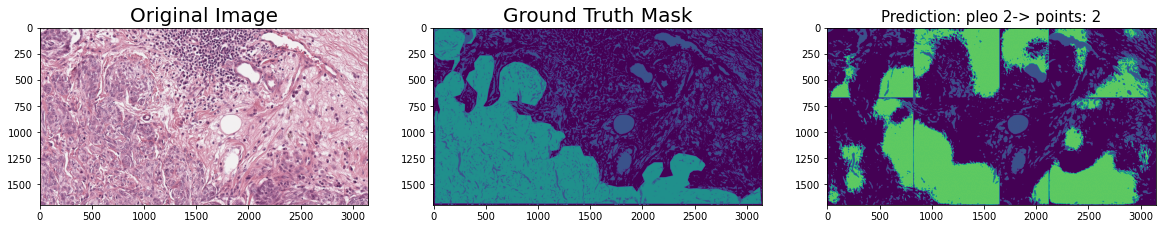

In [33]:
#test
test_dataset = BuildingsDataset_Head(
        image_paths = test_data, 
        annotations_file = annotations_file,
        class_rgb_values=select_class_rgb_values, 
        width=width, height=height, 
        num_patches = num_patches,
        num_classes = num_classes,
        label_dict=label_dict, 
        transform = albumentations_transform_test, 
        level = level,
        staining=False, 
        white_mask_application =True, 
        tumor_id = tumor_id, 
        dataset_type = dataset_type,
        overlap =200, 
        batch_size = 1,
        model = best_model,
        resize = True)

if dataset_type == "tubule_formation_segmentation": 
    image, gt_mask, pred_mask, areas = test_dataset[11]
    visualize(
    max_values = None,
    areas = areas,
    dict=label_dict,
    original_image = image,
    ground_truth_mask = gt_mask,
    predicted_mask = pred_mask,
    )
if dataset_type == "pleomorphism_segmentation": 
    image, gt_mask, pred_mask, max_values = test_dataset[11]
    visualize(
    max_values = max_values, 
    areas = None,
    dict=label_dict,
    original_image = image,
    ground_truth_mask = gt_mask,
    predicted_mask = pred_mask,
    )    
else: 
    image, gt_mask, pred_mask = test_dataset[8]
    visualize(
        max_values = None,
        areas = None,
        dict=label_dict,
        original_image = image,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
    )

[0.0, 1.0, 2.0, 3.0, 4.0]


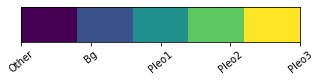

In [16]:
#plot color information
plt.figure(figsize=(len(label_dict),5))
bounds = list(range(0, len(label_dict)))
ax = plt.subplot()
fig = plt.imshow(np.array([[v for k,v in label_dict.items()]]), vmin=0, vmax=len(label_dict)-1, cmap='viridis',  extent=[0,len(label_dict)-1,0,0.5])
div = len(label_dict)/ len(label_dict)
t = round(-1* div,2)
ticks = []
for i in range(0, len(label_dict)): 
    t = t+div
    ticks.append(t)
print(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels([k for k,v in label_dict.items()], rotation = 40) 
plt.yticks([])
plt.show()
